---
title: Relationships
---

# Relationships: Modeling Entity Connections

Relational databases model the real world by representing entities and the **relationships** between them.
Building on the [Foreign Keys](030-foreign-keys.md) chapter—which covered referential integrity and foreign key modifiers—and the [Diagramming](040-diagrams.ipynb) chapter—which introduced the visual notation—this chapter focuses on the **patterns** that emerge from different combinations of uniqueness and referential constraints.

Understanding these patterns is essential for designing schemas that accurately represent business rules, data dependencies, and workflow structures.
Throughout this chapter, we'll use diagrams to visualize each pattern, reinforcing the connection between table definitions and their visual representation.

```{admonition} Learning Objectives
:class: note

By the end of this chapter, you will:
- Understand how foreign key placement determines relationship cardinality
- Design one-to-one, one-to-many, and many-to-many relationships
- Use association tables for complex relationships
- Build hierarchies and sequences using cascading foreign keys
- Apply the parameterization pattern for method/parameter combinations
- Model directed graphs using renamed foreign keys
```

# Relationship Fundamentals

Relationships between tables are established through **referential constraints** (foreign keys) combined with **uniqueness constraints** (primary keys and unique indexes).

```{card} Relationship Building Blocks
**Foreign keys** establish connections between tables:
- A foreign key in the child references the primary key of the parent
- The parent side always has cardinality of exactly **one**

**Uniqueness constraints** determine cardinality on the child side:
- No constraint on foreign key: **many** children per parent (one-to-many)
- Unique constraint on foreign key: **one** child per parent (one-to-one)
- Foreign key is entire primary key: **at most one** child per parent (one-to-one extension)
```

In DataJoint, foreign keys also participate in the **relational workflow model**: each dependency not only enforces referential integrity but also prescribes the order of operations.
When table B references table A, A must be populated before B.
The resulting schema is a directed acyclic graph (DAG) whose arrows describe both data relationships and workflow execution order.

```{seealso}
See [Relational Workflows](../20-concepts/05-workflows.md) for the theoretical foundation of workflow dependencies.
```

# Setup

First, we import DataJoint and create a schema for our examples:

In [1]:
import datajoint as dj

schema = dj.Schema('relationships_tutorial')

[2025-12-18 16:08:45,344][INFO]: DataJoint 0.14.6 connected to dev@db:3306


# One-to-Many Relationships

The **one-to-many** relationship is the most common pattern: one parent entity can have multiple associated child entities, but each child belongs to exactly one parent.

## Pattern 1: Foreign Key as Secondary Attribute

When the foreign key is a **secondary attribute** (below the `---` line), the child table has its own independent primary key.

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Customer(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(60)
    """

@schema
class Account(dj.Manual):
    definition = """
    account_id : int unsigned     # account's own identity
    ---
    -> Customer                   # foreign key as secondary attribute
    open_date : date
    balance : decimal(10,2)
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE customer (
    customer_id INT UNSIGNED NOT NULL,
    full_name VARCHAR(60) NOT NULL,
    PRIMARY KEY (customer_id)
);

CREATE TABLE account (
    account_id INT UNSIGNED NOT NULL COMMENT 'account own identity',
    customer_id INT UNSIGNED NOT NULL,
    open_date DATE NOT NULL,
    balance DECIMAL(10,2) NOT NULL,
    PRIMARY KEY (account_id),
    FOREIGN KEY (customer_id) REFERENCES customer(customer_id)
);
```
````
`````

**Characteristics:**
- Each account has its own independent identity (`account_id`)
- Each account belongs to exactly one customer
- Each customer can have multiple accounts (or none)
- In diagrams: shown as a **dashed line**

In [2]:
# create a new tutorial schema
import datajoint as dj
schema = dj.Schema('relationships_tutorial')

In [3]:
# Pattern 1: Foreign key as secondary attribute (dashed line)
@schema
class Customer(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(60)
    """

@schema
class AccountIndependent(dj.Manual):
    definition = """
    account_id : int unsigned     # account's own identity
    ---
    -> Customer                   # foreign key as secondary attribute
    open_date : date
    balance : decimal(10,2)
    """

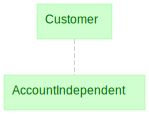

In [4]:
# View the diagram - notice the dashed line (secondary FK)
dj.Diagram(schema)

## Pattern 2: Foreign Key in Composite Primary Key

When the foreign key is **part of the primary key** (above `---`), the child's identity includes the parent's identity.

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Customer(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(60)
    """

@schema
class Account(dj.Manual):
    definition = """
    -> Customer                   # foreign key in primary key
    account_num : int unsigned    # account number within customer
    ---
    open_date : date
    balance : decimal(10,2)
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE customer (
    customer_id INT UNSIGNED NOT NULL,
    full_name VARCHAR(60) NOT NULL,
    PRIMARY KEY (customer_id)
);

CREATE TABLE account (
    customer_id INT UNSIGNED NOT NULL,
    account_num INT UNSIGNED NOT NULL COMMENT 'account number within customer',
    open_date DATE NOT NULL,
    balance DECIMAL(10,2) NOT NULL,
    PRIMARY KEY (customer_id, account_num),
    FOREIGN KEY (customer_id) REFERENCES customer(customer_id)
);
```
````
`````

**Characteristics:**
- Accounts are identified **within the context of their customer**
- Account #3 for Customer A is different from Account #3 for Customer B
- The primary key `(customer_id, account_num)` cascades through foreign keys
- In diagrams: shown as a **thin solid line**

**Key difference**: With a dashed line, `account_id` must be globally unique.
With a thin solid line, `account_num` only needs to be unique within each customer.

In [5]:
# Pattern 2: Foreign key in composite primary key (thin solid line)
@schema
class AccountContained(dj.Manual):
    definition = """
    -> Customer                   # foreign key in primary key
    account_num : int unsigned    # account number within customer
    ---
    open_date : date
    balance : decimal(10,2)
    """

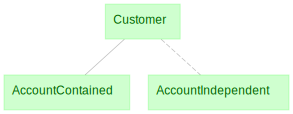

In [6]:
# View the diagram - notice the thin solid line (FK in primary key)
dj.Diagram(schema)

## Optional One-to-Many with Nullable Foreign Key

To allow children without a parent reference, use the `nullable` modifier:

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Account(dj.Manual):
    definition = """
    account_id : int unsigned
    ---
    -> [nullable] Customer        # optional owner
    open_date : date
    balance : decimal(10,2)
    """

# Accounts can exist without an assigned customer
Account.insert1({
    'account_id': 9999,
    'customer_id': None,          # no owner yet
    'open_date': '2024-01-01',
    'balance': 0.00
})
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE account (
    account_id INT UNSIGNED NOT NULL,
    customer_id INT UNSIGNED NULL,    -- allows NULL
    open_date DATE NOT NULL,
    balance DECIMAL(10,2) NOT NULL,
    PRIMARY KEY (account_id),
    FOREIGN KEY (customer_id) REFERENCES customer(customer_id)
);
```
````
`````

```{admonition} Nullable Foreign Keys in Primary Key
:class: warning

Foreign keys that are part of the primary key **cannot be made nullable**.
Primary key attributes must always have values.
The `nullable` modifier only applies to secondary attributes (below `---`).
```

# One-to-One Relationships

A **one-to-one** relationship ensures that each parent has **at most one** associated child.
There are several ways to achieve this.

## Pattern 1: Foreign Key as Entire Primary Key (Extension)

The strongest one-to-one relationship occurs when the foreign key **is** the entire primary key of the child table.

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Customer(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(60)
    """

@schema
class CustomerPreferences(dj.Manual):
    definition = """
    -> Customer                   # foreign key IS the primary key
    ---
    theme : varchar(20)
    notification_email : varchar(100)
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE customer (
    customer_id INT UNSIGNED NOT NULL,
    full_name VARCHAR(60) NOT NULL,
    PRIMARY KEY (customer_id)
);

CREATE TABLE customer_preferences (
    customer_id INT UNSIGNED NOT NULL,
    theme VARCHAR(20) NOT NULL,
    notification_email VARCHAR(100) NOT NULL,
    PRIMARY KEY (customer_id),
    FOREIGN KEY (customer_id) REFERENCES customer(customer_id)
);
```
````
`````

**Characteristics:**
- `CustomerPreferences` shares the same identity as `Customer`
- At most one preferences record per customer
- In diagrams: shown as a **thick solid line**
- Table name is **not underlined** (no new dimension introduced)

**Why use separate tables for one-to-one?**
- **Modularity**: Separate optional data from required data
- **Access control**: Different permissions for different data
- **Avoiding NULL columns**: Instead of nullable columns, use a separate table
- **Workflow stages**: Each table represents a processing step

In [7]:
# Pattern 1: Foreign key as entire primary key (thick solid line)
@schema
class CustomerPreferences(dj.Manual):
    definition = """
    -> Customer                   # foreign key IS the primary key
    ---
    theme : varchar(20)
    notification_email : varchar(100)
    """

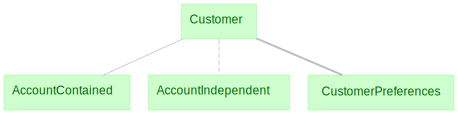

In [8]:
# View the diagram - notice the thick solid line (extension/one-to-one)
dj.Diagram(schema)

## Pattern 2: Unique Foreign Key (Reference)

Adding the `unique` modifier to a secondary foreign key creates a one-to-one relationship while maintaining independent identity:

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Employee(dj.Manual):
    definition = """
    employee_id : int unsigned
    ---
    full_name : varchar(60)
    """

@schema
class ParkingSpot(dj.Manual):
    definition = """
    spot_id : int unsigned        # spot has its own identity
    ---
    -> [unique] Employee          # at most one spot per employee
    location : varchar(30)
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE employee (
    employee_id INT UNSIGNED NOT NULL,
    full_name VARCHAR(60) NOT NULL,
    PRIMARY KEY (employee_id)
);

CREATE TABLE parking_spot (
    spot_id INT UNSIGNED NOT NULL,
    employee_id INT UNSIGNED NOT NULL,
    location VARCHAR(30) NOT NULL,
    PRIMARY KEY (spot_id),
    UNIQUE KEY (employee_id),
    FOREIGN KEY (employee_id) REFERENCES employee(employee_id)
);
```
````
`````

**Characteristics:**
- Each parking spot has its own identity (`spot_id`)
- The `unique` constraint ensures one spot per employee maximum
- In diagrams: shown as a **dashed line** (uniqueness not visible)

In [9]:
# Pattern 2: Unique foreign key (dashed line, uniqueness not visible)
@schema
class Employee(dj.Manual):
    definition = """
    employee_id : int unsigned
    ---
    full_name : varchar(60)
    """

@schema
class ParkingSpot(dj.Manual):
    definition = """
    spot_id : int unsigned        # spot has its own identity
    ---
    -> [unique] Employee          # at most one spot per employee
    location : varchar(30)
    """

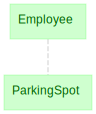

In [10]:
# View the diagram - notice the dashed line (unique constraint NOT visible!)
dj.Diagram(Employee) + 1

## Pattern 3: Optional One-to-One

Combine `nullable` and `unique` for an optional one-to-one relationship:

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class ParkingSpot(dj.Manual):
    definition = """
    spot_id : int unsigned
    ---
    -> [nullable, unique] Employee   # optional, but exclusive
    location : varchar(30)
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE parking_spot (
    spot_id INT UNSIGNED NOT NULL,
    employee_id INT UNSIGNED NULL,    -- can be unassigned
    location VARCHAR(30) NOT NULL,
    PRIMARY KEY (spot_id),
    UNIQUE KEY (employee_id),         -- but exclusive when assigned
    FOREIGN KEY (employee_id) REFERENCES employee(employee_id)
);
```
````
`````

Multiple spots can be unassigned (NULL), but each employee can be assigned at most one spot.

# Many-to-Many Relationships

A **many-to-many** relationship allows entities from both sides to be connected to multiple entities on the other side.
This requires an **association table** (also called junction table or bridge table).

## Basic Association Table

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Student(dj.Manual):
    definition = """
    student_id : int unsigned
    ---
    student_name : varchar(60)
    """

@schema
class Course(dj.Manual):
    definition = """
    course_code : char(8)
    ---
    course_title : varchar(100)
    """

@schema
class Enrollment(dj.Manual):
    definition = """
    -> Student                    # part of composite primary key
    -> Course                     # part of composite primary key
    ---
    enrollment_date : date
    grade : enum('A', 'B', 'C', 'D', 'F', 'IP')
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE student (
    student_id INT UNSIGNED NOT NULL,
    student_name VARCHAR(60) NOT NULL,
    PRIMARY KEY (student_id)
);

CREATE TABLE course (
    course_code CHAR(8) NOT NULL,
    course_title VARCHAR(100) NOT NULL,
    PRIMARY KEY (course_code)
);

CREATE TABLE enrollment (
    student_id INT UNSIGNED NOT NULL,
    course_code CHAR(8) NOT NULL,
    enrollment_date DATE NOT NULL,
    grade ENUM('A', 'B', 'C', 'D', 'F', 'IP') NOT NULL,
    PRIMARY KEY (student_id, course_code),
    FOREIGN KEY (student_id) REFERENCES student(student_id),
    FOREIGN KEY (course_code) REFERENCES course(course_code)
);
```
````
`````

**Characteristics:**
- `Enrollment` has a composite primary key from both parents
- Each student can enroll in many courses
- Each course can have many students
- Each student-course combination appears at most once
- Association table can have its own attributes (grade, enrollment_date)

In [11]:
# Many-to-many with association table
@schema
class Student(dj.Manual):
    definition = """
    student_id : int unsigned
    ---
    student_name : varchar(60)
    """

@schema
class Course(dj.Manual):
    definition = """
    course_code : char(8)
    ---
    course_title : varchar(100)
    """

@schema
class Enrollment(dj.Manual):
    definition = """
    -> Student                    # part of composite primary key
    -> Course                     # part of composite primary key
    ---
    enrollment_date : date
    grade : enum('A', 'B', 'C', 'D', 'F', 'IP')
    """

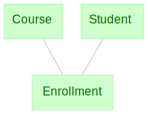

In [12]:
# View the many-to-many diagram
dj.Diagram(Student) + dj.Diagram(Course) + dj.Diagram(Enrollment)

## Enums vs. Lookup Tables for Valid Values

In the `Enrollment` example above, we used an **enum** to restrict `grade` to valid values: `enum('A', 'B', 'C', 'D', 'F', 'IP')`.
An alternative approach uses a **lookup table** to define valid grades.

Both approaches enforce data integrity, but they have different trade-offs:

`````{tab-set}
````{tab-item} Using Enum
:sync: enum
```python
@schema
class Enrollment(dj.Manual):
    definition = """
    -> Student
    -> Course
    ---
    enrollment_date : date
    grade : enum('A', 'B', 'C', 'D', 'F', 'IP')
    """
```
````
````{tab-item} Using Lookup Table
:sync: lookup
```python
@schema
class LetterGrade(dj.Lookup):
    definition = """
    grade : char(2)
    ---
    grade_point = null : decimal(3,2)
    description : varchar(30)
    """
    contents = [
        ('A', 4.00, 'Excellent'),
        ('B', 3.00, 'Good'),
        ('C', 2.00, 'Satisfactory'),
        ('D', 1.00, 'Passing'),
        ('F', 0.00, 'Failing'),
        ('IP', None, 'In Progress'),
    ]

@schema
class EnrollmentWithLookup(dj.Manual):
    definition = """
    -> Student
    -> Course
    ---
    enrollment_date : date
    -> LetterGrade
    """
```
````
`````

```{list-table} Enum vs. Lookup Table Comparison
:header-rows: 1
:widths: 15 42 43

* - Aspect
  - Enum
  - Lookup Table
* - **Associated data**
  - Cannot store additional attributes (e.g., grade points)
  - Can include related data like grade points, descriptions
* - **Modifications**
  - Requires `ALTER TABLE` to add/remove values
  - Add or remove rows without schema changes
* - **Querying**
  - Values are inline; no join needed
  - Requires join to access the value or related data
* - **Referential integrity**
  - Enforced by column type
  - Enforced by foreign key constraint
* - **Complexity**
  - Simple, self-contained
  - Additional table to manage
* - **Reuse**
  - Must repeat enum definition in each table
  - Single source of truth; multiple tables can reference it
```

```{admonition} When to Use Each Approach
:class: tip

**Use enums when:**
- The set of values is small and unlikely to change
- No additional attributes are associated with each value
- You want to minimize schema complexity

**Use lookup tables when:**
- Values need associated attributes (e.g., grade points, descriptions)
- The set of values may change without requiring schema migration
- Multiple tables reference the same set of values
- You need to query or report on the valid values themselves
```

```{seealso}
See the [Lookup Tables](020-lookup-tables.ipynb) chapter for more details on creating and using lookup tables.
```

In [ ]:
# Lookup table approach for grades
@schema
class LetterGrade(dj.Lookup):
    definition = """
    grade : char(2)
    ---
    grade_point = null : decimal(3,2)
    description : varchar(30)
    """
    contents = [
        ('A', 4.00, 'Excellent'),
        ('B', 3.00, 'Good'),
        ('C', 2.00, 'Satisfactory'),
        ('D', 1.00, 'Passing'),
        ('F', 0.00, 'Failing'),
        ('IP', None, 'In Progress'),
    ]

@schema
class EnrollmentWithLookup(dj.Manual):
    definition = """
    -> Student
    -> Course
    ---
    enrollment_date : date
    -> LetterGrade
    """

In [ ]:
# View the lookup table contents - notice the associated grade points
LetterGrade()

In [ ]:
# Compare the diagrams: EnrollmentWithLookup has an additional dependency on LetterGrade
dj.Diagram(Student) + dj.Diagram(Course) + dj.Diagram(LetterGrade) + dj.Diagram(EnrollmentWithLookup)

## Constrained Many-to-Many

By moving one foreign key below `---` with a `unique` constraint, you can create constrained relationships:

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
# Each customer has at most one account, but accounts can be shared
@schema
class CustomerAccount(dj.Manual):
    definition = """
    -> Customer                   # primary key
    ---
    -> Account                    # each customer links to one account
    """

# With unique constraint: each account belongs to at most one customer
@schema
class AccountOwnership(dj.Manual):
    definition = """
    -> Account                    # primary key
    ---
    -> [unique] Customer          # each customer owns at most one account
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
-- Each customer has at most one account
CREATE TABLE customer_account (
    customer_id INT UNSIGNED NOT NULL,
    account_id INT UNSIGNED NOT NULL,
    PRIMARY KEY (customer_id),
    FOREIGN KEY (customer_id) REFERENCES customer(customer_id),
    FOREIGN KEY (account_id) REFERENCES account(account_id)
);

-- Each customer owns at most one account (bidirectional constraint)
CREATE TABLE account_ownership (
    account_id INT UNSIGNED NOT NULL,
    customer_id INT UNSIGNED NOT NULL,
    PRIMARY KEY (account_id),
    UNIQUE KEY (customer_id),
    FOREIGN KEY (account_id) REFERENCES account(account_id),
    FOREIGN KEY (customer_id) REFERENCES customer(customer_id)
);
```
````
`````

# Hierarchies

**Hierarchies** are cascading one-to-many relationships that create tree structures.
Each level adds a new dimension to the composite primary key.

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Study(dj.Manual):
    definition = """
    study : varchar(8)            # study code
    ---
    investigator : varchar(60)
    study_description : varchar(255)
    """

@schema
class Subject(dj.Manual):
    definition = """
    -> Study
    subject_id : varchar(12)      # subject within study
    ---
    species : enum('human', 'primate', 'rodent')
    date_of_birth = null : date
    """

@schema
class Session(dj.Manual):
    definition = """
    -> Subject
    session : smallint unsigned   # session within subject
    ---
    session_date : date
    operator : varchar(60)
    """

@schema
class Scan(dj.Manual):
    definition = """
    -> Session
    scan : smallint unsigned      # scan within session
    ---
    scan_time : time
    scan_type : varchar(30)
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE study (
    study VARCHAR(8) NOT NULL,
    investigator VARCHAR(60) NOT NULL,
    study_description VARCHAR(255) NOT NULL,
    PRIMARY KEY (study)
);

CREATE TABLE subject (
    study VARCHAR(8) NOT NULL,
    subject_id VARCHAR(12) NOT NULL,
    species ENUM('human', 'primate', 'rodent') NOT NULL,
    date_of_birth DATE NULL,
    PRIMARY KEY (study, subject_id),
    FOREIGN KEY (study) REFERENCES study(study)
);

CREATE TABLE session (
    study VARCHAR(8) NOT NULL,
    subject_id VARCHAR(12) NOT NULL,
    session SMALLINT UNSIGNED NOT NULL,
    session_date DATE NOT NULL,
    operator VARCHAR(60) NOT NULL,
    PRIMARY KEY (study, subject_id, session),
    FOREIGN KEY (study, subject_id) REFERENCES subject(study, subject_id)
);

CREATE TABLE scan (
    study VARCHAR(8) NOT NULL,
    subject_id VARCHAR(12) NOT NULL,
    session SMALLINT UNSIGNED NOT NULL,
    scan SMALLINT UNSIGNED NOT NULL,
    scan_time TIME NOT NULL,
    scan_type VARCHAR(30) NOT NULL,
    PRIMARY KEY (study, subject_id, session, scan),
    FOREIGN KEY (study, subject_id, session)
        REFERENCES session(study, subject_id, session)
);
```
````
`````

**Key features of hierarchies:**
- Primary keys **cascade** through the hierarchy
- `Scan`'s primary key is `(study, subject_id, session, scan)`
- Direct joins work across any levels: `Study * Scan` is valid
- In diagrams: chain of **thin solid lines**

This pattern is common in scientific data organization (BIDS, NWB) where data is structured as Study → Subject → Session → Data.

In [13]:
# Hierarchy pattern: cascading one-to-many relationships
@schema
class Study(dj.Manual):
    definition = """
    study : varchar(8)            # study code
    ---
    investigator : varchar(60)
    study_description : varchar(255)
    """

@schema
class Subject(dj.Manual):
    definition = """
    -> Study
    subject_id : varchar(12)      # subject within study
    ---
    species : enum('human', 'primate', 'rodent')
    date_of_birth = null : date
    """

@schema
class Session(dj.Manual):
    definition = """
    -> Subject
    session : smallint unsigned   # session within subject
    ---
    session_date : date
    operator : varchar(60)
    """

@schema
class Scan(dj.Manual):
    definition = """
    -> Session
    scan : smallint unsigned      # scan within session
    ---
    scan_time : time
    scan_type : varchar(30)
    """

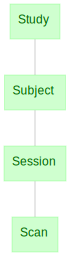

In [14]:
# View the hierarchy diagram - chain of thin solid lines
dj.Diagram(Study) + 10

# Sequences

**Sequences** are cascading one-to-one relationships representing workflow steps.
Each step extends the identity of the previous step.

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Order(dj.Manual):
    definition = """
    order_id : int unsigned
    ---
    order_date : date
    customer : varchar(60)
    """

@schema
class Shipment(dj.Manual):
    definition = """
    -> Order                      # same identity as Order
    ---
    ship_date : date
    carrier : varchar(30)
    """

@schema
class Delivery(dj.Manual):
    definition = """
    -> Shipment                   # same identity as Shipment (and Order)
    ---
    delivery_date : date
    signature : varchar(60)
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE order_ (
    order_id INT UNSIGNED NOT NULL,
    order_date DATE NOT NULL,
    customer VARCHAR(60) NOT NULL,
    PRIMARY KEY (order_id)
);

CREATE TABLE shipment (
    order_id INT UNSIGNED NOT NULL,
    ship_date DATE NOT NULL,
    carrier VARCHAR(30) NOT NULL,
    PRIMARY KEY (order_id),
    FOREIGN KEY (order_id) REFERENCES order_(order_id)
);

CREATE TABLE delivery (
    order_id INT UNSIGNED NOT NULL,
    delivery_date DATE NOT NULL,
    signature VARCHAR(60) NOT NULL,
    PRIMARY KEY (order_id),
    FOREIGN KEY (order_id) REFERENCES shipment(order_id)
);
```
````
`````

**Key features of sequences:**
- All tables share the same primary key (`order_id`)
- Each step is optional—not every order is shipped, not every shipment is delivered
- Direct queries across steps: `Order * Delivery` works without including `Shipment`
- In diagrams: chain of **thick solid lines**

In [15]:
# Sequence pattern: cascading one-to-one relationships
@schema
class Order(dj.Manual):
    definition = """
    order_id : int unsigned
    ---
    order_date : date
    customer : varchar(60)
    """

@schema
class Shipment(dj.Manual):
    definition = """
    -> Order                      # same identity as Order
    ---
    ship_date : date
    carrier : varchar(30)
    """

@schema
class Delivery(dj.Manual):
    definition = """
    -> Shipment                   # same identity as Shipment (and Order)
    ---
    delivery_date : date
    signature : varchar(60)
    """

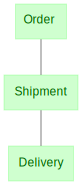

In [16]:
# View the sequence diagram - chain of thick solid lines
dj.Diagram(Order) + dj.Diagram(Shipment) + dj.Diagram(Delivery)

# Parameterization

The **parameterization pattern** applies different methods, algorithms, or parameters to the same entities.
The association table itself becomes the entity of interest.

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Image(dj.Manual):
    definition = """
    image_id : int unsigned
    ---
    raw_image : longblob
    """

@schema
class EnhanceMethod(dj.Lookup):
    definition = """
    method_id : int unsigned
    ---
    method_name : varchar(30)
    method_description : varchar(255)
    """
    contents = [
        (1, 'sharpen', 'Sharpen edges using unsharp mask'),
        (2, 'denoise', 'Remove noise using median filter'),
        (3, 'contrast', 'Enhance contrast using histogram equalization'),
    ]

@schema
class EnhancedImage(dj.Computed):
    definition = """
    -> Image
    -> EnhanceMethod
    ---
    enhanced_image : longblob
    processing_time : float
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE image (
    image_id INT UNSIGNED NOT NULL,
    raw_image LONGBLOB NOT NULL,
    PRIMARY KEY (image_id)
);

CREATE TABLE enhance_method (
    method_id INT UNSIGNED NOT NULL,
    method_name VARCHAR(30) NOT NULL,
    method_description VARCHAR(255) NOT NULL,
    PRIMARY KEY (method_id)
);

CREATE TABLE enhanced_image (
    image_id INT UNSIGNED NOT NULL,
    method_id INT UNSIGNED NOT NULL,
    enhanced_image LONGBLOB NOT NULL,
    processing_time FLOAT NOT NULL,
    PRIMARY KEY (image_id, method_id),
    FOREIGN KEY (image_id) REFERENCES image(image_id),
    FOREIGN KEY (method_id) REFERENCES enhance_method(method_id)
);
```
````
`````

**Characteristics:**
- Same image processed with multiple methods
- Same method applied to multiple images
- Results stored with composite key `(image_id, method_id)`
- Typical in computational workflows with parameter sweeps

In [17]:
# Parameterization pattern
@schema
class Image(dj.Manual):
    definition = """
    image_id : int unsigned
    ---
    raw_image : longblob
    """

@schema
class EnhanceMethod(dj.Lookup):
    definition = """
    method_id : int unsigned
    ---
    method_name : varchar(30)
    method_description : varchar(255)
    """
    contents = [
        (1, 'sharpen', 'Sharpen edges using unsharp mask'),
        (2, 'denoise', 'Remove noise using median filter'),
        (3, 'contrast', 'Enhance contrast using histogram equalization'),
    ]

@schema
class EnhancedImage(dj.Computed):
    definition = """
    -> Image
    -> EnhanceMethod
    ---
    enhanced_image : longblob
    processing_time : float
    """

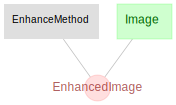

In [18]:
# View the parameterization diagram
dj.Diagram(Image) + dj.Diagram(EnhanceMethod) + dj.Diagram(EnhancedImage)

# Directed Graphs

**Directed graphs** model relationships where entities of the same type connect to each other.
Use **renamed foreign keys** to reference the same parent table multiple times.

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Neuron(dj.Manual):
    definition = """
    neuron_id : int unsigned
    ---
    neuron_type : enum('excitatory', 'inhibitory')
    layer : tinyint unsigned
    """

@schema
class Synapse(dj.Manual):
    definition = """
    synapse_id : int unsigned
    ---
    -> Neuron.proj(presynaptic='neuron_id')
    -> Neuron.proj(postsynaptic='neuron_id')
    strength : float
    synapse_type : varchar(30)
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE neuron (
    neuron_id INT UNSIGNED NOT NULL,
    neuron_type ENUM('excitatory', 'inhibitory') NOT NULL,
    layer TINYINT UNSIGNED NOT NULL,
    PRIMARY KEY (neuron_id)
);

CREATE TABLE synapse (
    synapse_id INT UNSIGNED NOT NULL,
    presynaptic INT UNSIGNED NOT NULL,
    postsynaptic INT UNSIGNED NOT NULL,
    strength FLOAT NOT NULL,
    synapse_type VARCHAR(30) NOT NULL,
    PRIMARY KEY (synapse_id),
    FOREIGN KEY (presynaptic) REFERENCES neuron(neuron_id),
    FOREIGN KEY (postsynaptic) REFERENCES neuron(neuron_id)
);
```
````
`````

The `.proj()` operator renames the foreign key attribute:
- `presynaptic` references `Neuron.neuron_id`
- `postsynaptic` references `Neuron.neuron_id`

In diagrams, **orange dots** indicate renamed foreign keys.

**Other examples:**
- Employees and managers (both are employees)
- Cities connected by flights
- Users following other users

In [19]:
# Directed graph pattern with renamed foreign keys
@schema
class Neuron(dj.Manual):
    definition = """
    neuron_id : int unsigned
    ---
    neuron_type : enum('excitatory', 'inhibitory')
    layer : tinyint unsigned
    """

@schema
class Synapse(dj.Manual):
    definition = """
    synapse_id : int unsigned
    ---
    -> Neuron.proj(presynaptic='neuron_id')
    -> Neuron.proj(postsynaptic='neuron_id')
    strength : float
    synapse_type : varchar(30)
    """

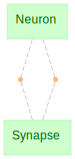

In [20]:
# View the diagram - notice the orange dots indicating renamed foreign keys
dj.Diagram(Neuron) + dj.Diagram(Synapse)

# Design Puzzle: Unique Designation

A common challenge: how to designate exactly one special item among many?
For example: each state has many cities, but exactly one capital.

**Requirements:**
1. Each city belongs to exactly one state
2. Each state has exactly one capital
3. A capital must be a city in that state

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class State(dj.Manual):
    definition = """
    state : char(2)               # two-letter state code
    ---
    state_name : varchar(30)
    """

@schema
class City(dj.Manual):
    definition = """
    -> State
    city_name : varchar(60)
    ---
    population : int unsigned
    capital = null : enum('YES')  # nullable enum for designation
    unique index(state, capital)  # only one 'YES' per state
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE state (
    state CHAR(2) NOT NULL,
    state_name VARCHAR(30) NOT NULL,
    PRIMARY KEY (state)
);

CREATE TABLE city (
    state CHAR(2) NOT NULL,
    city_name VARCHAR(60) NOT NULL,
    population INT UNSIGNED NOT NULL,
    capital ENUM('YES') NULL,
    PRIMARY KEY (state, city_name),
    UNIQUE KEY (state, capital),
    FOREIGN KEY (state) REFERENCES state(state)
);
```
````
`````

**How it works:**
- `capital` is NULL for non-capitals (most cities)
- `capital = 'YES'` for the capital city
- `unique index(state, capital)` ensures only one 'YES' per state
- NULL values don't violate uniqueness (multiple NULLs allowed)

This pattern works for team captains, default addresses, primary contacts, etc.

In [21]:
# Unique designation pattern
@schema
class State(dj.Manual):
    definition = """
    state : char(2)               # two-letter state code
    ---
    state_name : varchar(30)
    """

@schema
class City(dj.Manual):
    definition = """
    -> State
    city_name : varchar(60)
    ---
    population : int unsigned
    capital = null : enum('YES')  # nullable enum for designation
    unique index(state, capital)  # only one 'YES' per state
    """

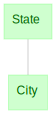

In [22]:
# View the diagram
dj.Diagram(State) + dj.Diagram(City)

# Relationship Summary

| Pattern | Foreign Key Position | Constraint | Cardinality | Diagram Line |
|---------|---------------------|------------|-------------|--------------|
| One-to-many (reference) | Secondary | None | 1:N | Dashed |
| One-to-many (containment) | Part of PK | None | 1:N | Thin solid |
| One-to-one (extension) | Entire PK | Inherent | 1:1 | Thick solid |
| One-to-one (reference) | Secondary | `unique` | 1:1 | Dashed |
| Optional relationship | Secondary | `nullable` | 1:0..N | Dashed |
| Optional one-to-one | Secondary | `nullable, unique` | 1:0..1 | Dashed |
| Many-to-many | Both in PK | None | M:N | Two thin solids |

```{admonition} Design Guidelines
:class: tip

1. **Prefer solid lines** when appropriate—they enable direct joins across levels
2. **Use composite primary keys** for hierarchies to cascade identity
3. **Use association tables** for many-to-many relationships
4. **Use thick solid lines** (extension) when child has no independent meaning
5. **Check table definitions** for `nullable` and `unique`—diagrams don't show them
```

```{admonition} Next Steps
:class: note

Now that you understand relationship patterns:
- **[Master-Part Tables](053-master-part.ipynb)** — Special pattern for composite entities
- **[Normalization](055-normalization.ipynb)** — Principles for organizing attributes
```

# Complete Schema Diagram

View all the tables we've created in this tutorial:

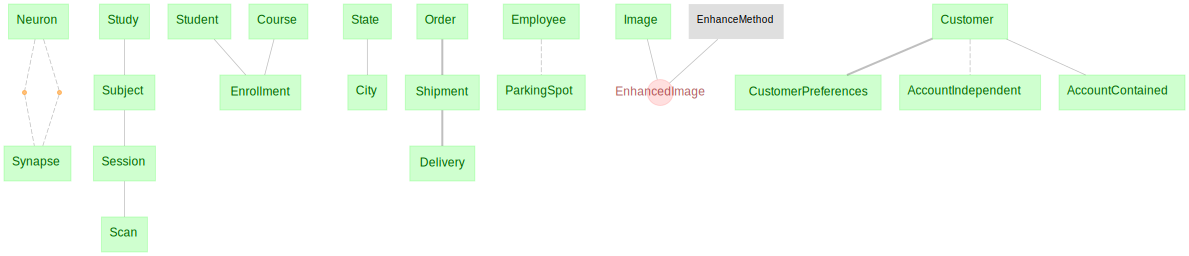

In [23]:
# View the entire schema
dj.Diagram(schema)

# Cleanup

Optionally drop the tutorial schema when done:

In [24]:
# drop the schema
schema.drop(force=True)